In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time


resultados = {
    "porcentaje": [],
    "media errores": [],
    "tiempo usado para reentrenar": []
}

err = np.empty((20, 25))

for porcen in  np.arange(0, 1, 0.05):
  # Ruta de la carpeta principal que contiene los datos
  folder_path = '/content/drive/MyDrive/TFM/UJI_LIB_DB_v2.2/db/'

  meses = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25"]
  tst = ["02", "03", "04", "05"]

  df_i = pd.DataFrame()
  df_o = pd.DataFrame()
  t_df_i = pd.DataFrame()
  t_df_o = pd.DataFrame()

  session = "01"


  # Train
  file_path = folder_path + session +  "/" + "trn01rss.csv"
  df_i = pd.concat([df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

  file_path = folder_path + session +  "/" + "trn01crd.csv"
  df_o = pd.concat([df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

  file_path = folder_path + session +  "/"+"trn01rss.csv"
  df_i = pd.read_csv(file_path, header=None)

  file_path = folder_path + session +  "/"+ "trn01crd.csv"
  df_o = pd.read_csv(file_path, header=None)



  # Cambia los valores de la planta por metros. La planta 3 será 0 metros, la planta 5 serán 3.7 metros
  df_o.iloc[:, 2] = df_o.iloc[:, 2].replace({3: 0, 5: 3.7})


  X_train = df_i
  y_train = df_o

  start_train = time.time()
  neigh = NearestNeighbors(n_neighbors=3)
  neigh.fit(X_train, y_train)
  end_train = time.time()


  for session in range(1, len(meses)):
      mes = meses[session]

      df_i = pd.DataFrame()
      df_o = pd.DataFrame()
      t_df_i = pd.DataFrame()
      t_df_o = pd.DataFrame()

      # Train
      file_path = folder_path + mes + "/" + "trn01rss.csv"
      df_i = pd.concat([df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

      file_path = folder_path + mes + "/" + "trn01crd.csv"
      df_o = pd.concat([df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

      df_o.iloc[:, 2] = df_o.iloc[:, 2].replace({3: 0, 5: 3.7})


      # Calcular el número de filas a sustituir (5%)
      num_rows_to_replace = int(len(X_train) * porcen)
      random_rows_indices = np.random.choice(len(X_train), num_rows_to_replace, replace=False)
      random_rows = X_train.iloc[random_rows_indices]

      for index, row in random_rows.iterrows():
          X_train.loc[index] = df_i.loc[index]
          y_train.loc[index] = df_o.loc[index]


      # kNN
      start_train = time.time()
      neigh.fit(X_train, y_train)
      end_train = time.time()



      # Test
      file_path = folder_path + mes + "/" + "tst01rss.csv"
      t_df_i = pd.concat([t_df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

      file_path = folder_path + mes + "/" + "tst01crd.csv"
      t_df_o = pd.concat([t_df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

      X_test = t_df_i
      y_test = t_df_o

      for rep in tst:
          file_path = folder_path + mes + "/" + "tst" + rep + "rss.csv"
          t_df_i = pd.concat([t_df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

          file_path = folder_path + mes + "/" + "tst" + rep + "crd.csv"
          t_df_o = pd.concat([t_df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

      X_test = t_df_i
      y_test = t_df_o

      start_pred = time.time()
      distances, indices = neigh.kneighbors(X_test)
      end_pred = time.time()

      errores = []

      for i in range(len(X_test)):
          errores_i = y_train.iloc[indices[i], :].mean(axis=0)
          distancia_euclidea = np.linalg.norm(y_test.iloc[i, :].values - errores_i.values)
          errores.append(distancia_euclidea)

      media_knn = np.mean(errores)
      err[int(porcen/0.05)][session] = media_knn

      if mes == "25":

        resultados["porcentaje"].append(porcen)
        resultados["media errores"].append(media_knn)
        # porcen * len(X_train) es el número de filas. Cada fila cuesta 10 segundos de sacar (6 obtener + 4 de moverse). Restamos 4 por el último movimiento.
        # multiplicamos por 24 para hacer el número de meses
        resultados["tiempo usado para reentrenar"].append(porcen * len(X_train) * 10 * 24)

# Convertir resultados a DataFrame
resultados_df = pd.DataFrame(resultados)

# Mostrar la tabla de resultados
print(resultados_df)

    porcentaje  media errores  tiempo usado para reentrenar
0         0.00       4.398981                           0.0
1         0.05       3.903411                        6912.0
2         0.10       3.781144                       13824.0
3         0.15       3.865492                       20736.0
4         0.20       3.916172                       27648.0
5         0.25       3.934653                       34560.0
6         0.30       3.785695                       41472.0
7         0.35       3.853956                       48384.0
8         0.40       3.776929                       55296.0
9         0.45       3.839432                       62208.0
10        0.50       3.817339                       69120.0
11        0.55       3.878591                       76032.0
12        0.60       3.797835                       82944.0
13        0.65       3.822552                       89856.0
14        0.70       3.899001                       96768.0
15        0.75       3.815263           

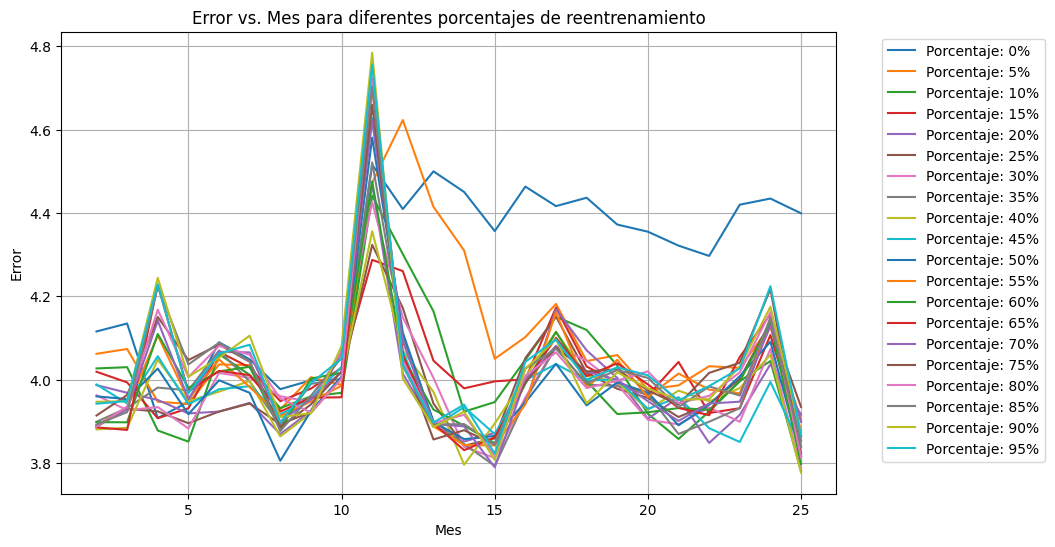

In [3]:
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Iterar sobre cada fila de err para trazar una línea para cada porcentaje excepto 0.90
for i in range(err.shape[0]):
  plt.plot(range(2, err.shape[1] + 1), err[i, 1:], label=f"Porcentaje: {i*5}%")

# Añadir etiquetas y título
plt.xlabel("Mes")
plt.ylabel("Error")
plt.title("Error vs. Mes para diferentes porcentajes de reentrenamiento")

# Mostrar el gráfico
plt.grid(True)

# Mostrar la leyenda fuera del gráfico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.show()

+---------------------+--------------------+------------------------------+
|     porcentaje      |   media errores    | tiempo usado para reentrenar |
+---------------------+--------------------+------------------------------+
|         0.0         | 4.398981325040997  |             0.0              |
|        0.05         | 3.903410601120713  |            6912.0            |
|         0.1         | 3.7811437578832265 |           13824.0            |
| 0.15000000000000002 | 3.8654920011482923 |           20736.0            |
|         0.2         | 3.9161718722073133 |           27648.0            |
|        0.25         | 3.934652965462861  |           34560.0            |
| 0.30000000000000004 | 3.785695480982545  |           41472.0            |
| 0.35000000000000003 | 3.8539558226587816 |      48384.00000000001       |
|         0.4         | 3.776929173060599  |           55296.0            |
|        0.45         | 3.8394315171901443 |           62208.0            |
|         0.

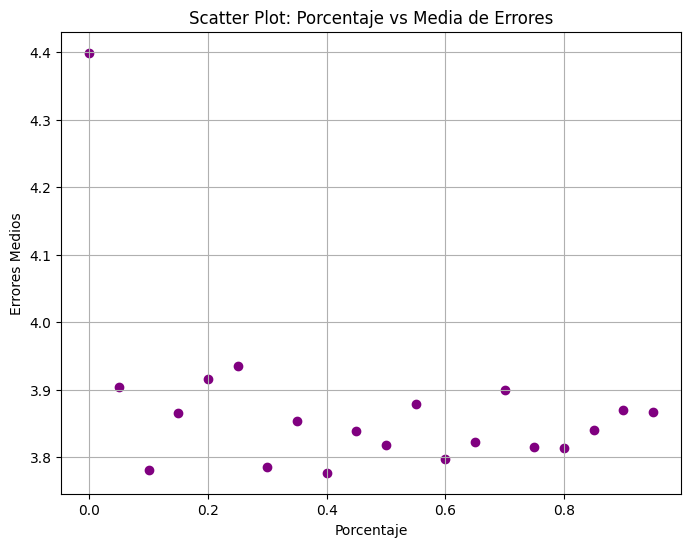

In [4]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Mostrar la tabla
print(tabulate(resultados_df, headers='keys', tablefmt='pretty', showindex=False))

# Datos del diccionario
porcentajes = resultados["porcentaje"]
errores_medios = resultados["media errores"]

# Crear el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(porcentajes, errores_medios, color='purple', marker='o')
plt.title("Scatter Plot: Porcentaje vs Media de Errores")
plt.xlabel("Porcentaje")
plt.ylabel("Errores Medios")
plt.grid(True)
plt.show()
